In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import sklearn 

%matplotlib inline 

In [2]:
housing = pd.read_csv('housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing['ocean_proximity'] = housing['ocean_proximity'].astype('category')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null category
dtypes: category(1), float64(9)
memory usage: 1.4 MB


In [4]:
housing.describe().round(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.0,20640.0,20640.0,20640.0,20433.0,20640.0,20640.0,20640.0,20640.0
mean,-119.6,35.6,28.6,2635.8,537.9,1425.5,499.5,3.9,206855.8
std,2.0,2.1,12.6,2181.6,421.4,1132.5,382.3,1.9,115395.6
min,-124.4,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1447.8,296.0,787.0,280.0,2.6,119600.0
50%,-118.5,34.3,29.0,2127.0,435.0,1166.0,409.0,3.5,179700.0
75%,-118.0,37.7,37.0,3148.0,647.0,1725.0,605.0,4.7,264725.0
max,-114.3,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500001.0


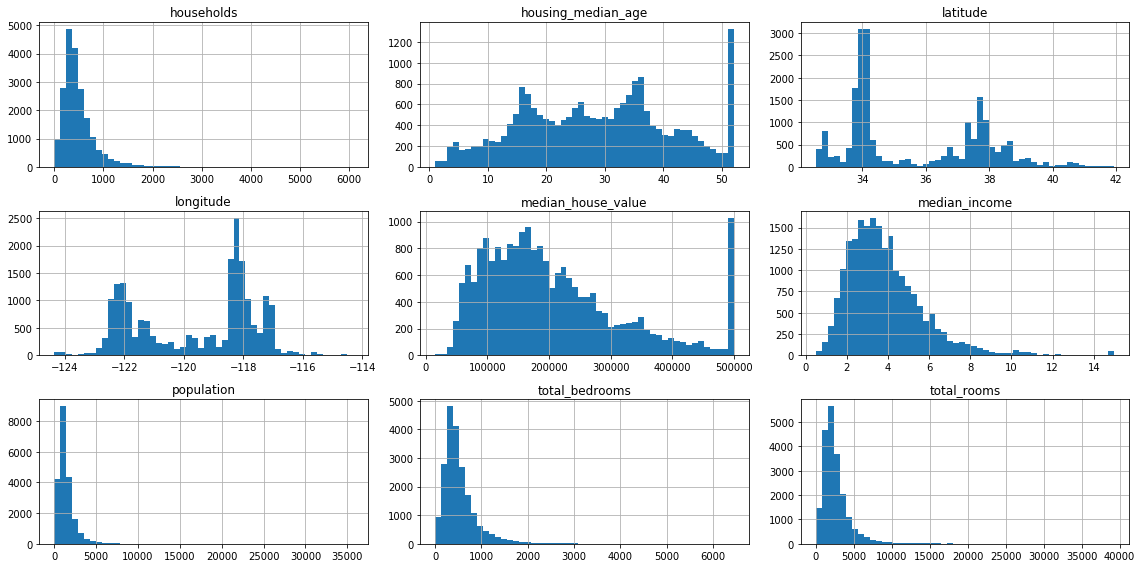

In [5]:
housing.hist(bins=50, figsize=(16, 8))
plt.tight_layout()
plt.show()

## Train test split

In [6]:
# Train and test data split 

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[ : test_set_size]
    train_indices = shuffled_indices[test_set_size : ]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
train_set, test_set = split_train_test(housing, 0.2)
print("{} train + {} test".format(len(train_set), len(test_set))) 

16512 train + 4128 test


In [8]:
# To ensure that a new test set will contain only the new
# instances, but will not contain any instance that was previously in the training set.

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [9]:
# Using scikit learn 
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, random_state=42, test_size=0.2)

## Stratified Sampling 

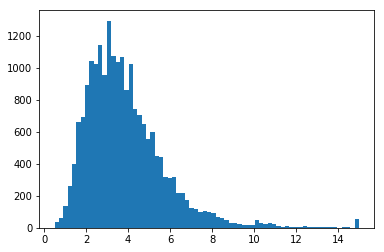

In [10]:
plt.hist(housing['median_income'], bins=70)
plt.show()

In [11]:
# merging all the categories greater than 5 into category 5
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [12]:
# Do stratified sampling based on the income category
#The folds are made by preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
# income category proportions in the full housing dataset
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [14]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [15]:
for set in (strat_test_set, strat_train_set):
    set.drop(["income_cat"], inplace=True, axis=1)

## Analyzing the data

In [16]:
housing = strat_train_set.copy()

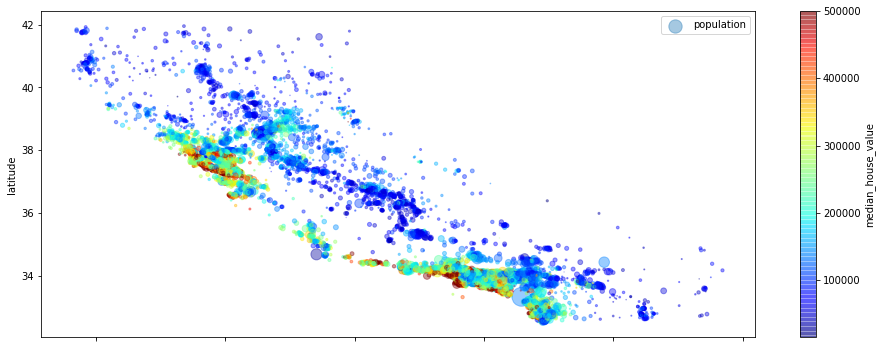

In [17]:
# The radius of each circle represents the district’s population (option s), 
# and the color represents the price (option c)

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(16,6))

plt.legend()

In [18]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

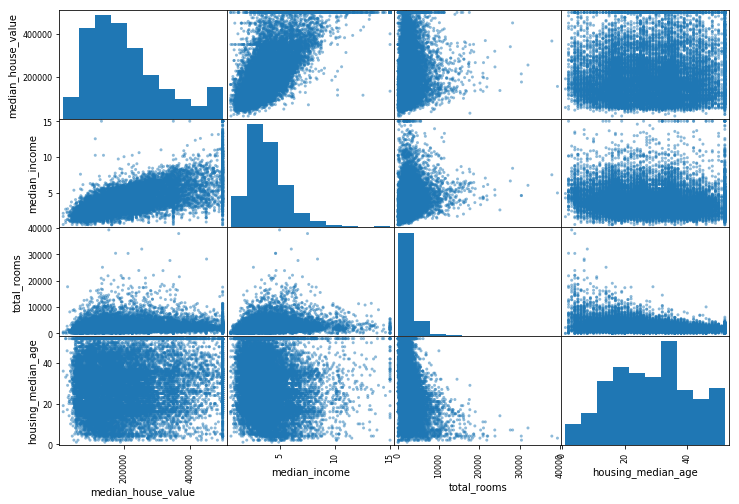

In [19]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

In [20]:
# Create new variables to make sense of the data 

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [21]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

## Missing values

In [25]:
# Drop missing rows 
housing.dropna(subset=['total_bedrooms'])

# Drop the column with missing values
housing.drop("total_bedrooms", axis=1)

# Imputing with mean or median 
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(value = median)

In [26]:
# Using sklearn
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

# df with numerical columns 
housing_num = housing.drop('ocean_proximity', axis=1)

<em> Only the total_bedrooms attribute had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, <br>so it is safer to apply the imputer to all the numerical attributes: </em> 

In [27]:
# The imputer has simply computed the median of each attribute and stored the result
# in its statistics_ instance variable

imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [28]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [29]:
X = imputer.transform(housing_num)

In [30]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Handling text and Categorical Attributes

In [31]:
# Converting text labels to numbers 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [32]:
print(encoder.classes_)

# issue with this representation is that ML algorithms will assume that two nearby
# values are more similar than two distant values. Not suitable when categories are 
# not sequential 

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [33]:
# One hot encoding 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# fit_transform() expects a 2D array, but housing_cat_encoded is a 1D array,
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [34]:
housing_cat_1hot.toarray() # Dense numpy array 

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [35]:
# apply both transformations (from text categories to integer categories, then
# from integer categories to one-hot vectors)

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer() # sparse_output = true for making a sparse matrix 
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot # this returns a dense NumPy array by default

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [36]:
a = np.matrix([[1, 2, 3, 4], [5, 6, 7, 8]])

# by specifying -1, we are just asking numpy to figure out the dimensions
b = a.reshape(-1, 2)

## Custom Transformers

<em> You will need to write
your own for tasks such as custom cleanup operations or combining specific
attributes. </em>

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): # TransformerMixin will add the fit_transform method
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do 
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room] # Column stack 
        else :
            return np.c_[X, rooms_per_household, population_per_household]

In [38]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

<br>
<em> There is nothing in Scikit-Learn
to handle Pandas DataFrames, so we need to write a simple custom transformer for
this task

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [40]:
selector = DataFrameSelector(['longitude', 'latitude'])
selector.transform(housing)

array([[-121.89,   37.29],
       [-121.93,   37.05],
       [-117.2 ,   32.77],
       ...,
       [-116.4 ,   34.09],
       [-118.01,   33.82],
       [-122.45,   37.77]])

<br><em> LabelBinarizer is not supposed to be used with X (Features), but is intended for labels only. Hence the fit and fit_transform methods are changed to include only single object y. But the Pipeline (which works on features) will try sending both X and y to it. Hence will return an error when using directly in a transformation pipeline 

In [41]:
from sklearn.base import TransformerMixin

class MyLabelBinarizer(TransformerMixin):
    
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
        
    def fit(self, X, y=0):
        self.encoder.fit(X)
        return self
    
    def transform(self, X, y=0):
        return self.encoder.transform(X)

In [42]:
enc = MyLabelBinarizer()
enc.fit_transform(housing_cat)

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Feature Scaling 

In [43]:
# subtracting the min value and dividing by the max minus the min
from sklearn.preprocessing import MinMaxScaler

# subtracts the mean value and then it divides by the variance so that the resulting
# distribution has unit variance.
from sklearn.preprocessing import StandardScaler

<em> standardization is much less affected by outliers

## Transformation Pipelines 

<em> Helps to do sequences of transformations

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_tr = num_pipeline.fit_transform(housing_num)

In [45]:
# full pipeline handling both numerical and categorical attributes

from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', MyLabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)

## Select and train a model

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, y=housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
# Testing on some data 
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared).round())

Predictions:	 [210645. 317769. 210956.  59219. 189748.]


In [48]:
print("Actual Values:\t", some_labels.values)

Actual Values:	 [286600. 340600. 196900.  46300. 254500.]


In [49]:
## Measuring the RMSE
from sklearn.metrics import mean_squared_error, r2_score

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) ; lin_rmse.round(0)

68628.0

In [50]:
housing_labels.mean()

206990.9207243217

<em> Compared to the average housing prices, RMSE value seems high as, around 68% of the data will fall within a range of $70,000.<br>  

In [51]:
## Trying a more powerful model 
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [52]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

<em> Is this model absolutely perfect ??

## Better Evaluation Using Cross-Validation

In [54]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(tree_reg, X=housing_prepared, y=housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

<em> Scikit-Learn cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (i.e., a negative
value), which is why the preceding code computes -scores
before calculating the square root.

In [55]:
rmse_scores = np.sqrt(-scores)

In [56]:
def display_scores(scores):
    print("Scores: ", scores.round())
    print("Mean: ", np.mean(scores))
    print("Standard deviation:", scores.std())

In [57]:
display_scores(rmse_scores)

Scores:  [68880. 68349. 71326. 70078. 71232. 74357. 70042. 70889. 74443. 68614.]
Mean:  70821.07523821194
Standard deviation: 2048.560752035275


In [58]:
lin_scores = cross_val_score(lin_reg, X=housing_prepared, y=housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores:  [66783. 66960. 70348. 74740. 68031. 71194. 64970. 68282. 71553. 67665.]
Mean:  69052.46136345083
Standard deviation: 2731.6740017983466


In [59]:
## Checking on Random Forest 

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(tree_mse)
forest_rmse

0.0

In [60]:
forest_scores = cross_val_score(forest_reg, X=housing_prepared, y=housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores:  [50719. 49081. 52073. 55078. 51964. 54131. 52086. 50104. 56029. 52179.]
Mean:  52344.25876158194
Standard deviation: 2070.2292178036614


<br><em>the score on the training set is still much lower than on the validation sets, meaning
that the model is still overfitting the training set

## Fine Tune the Model 

### Grid Search

<em>This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of
n_estimators and max_features hyperparameter values specified in the first dict, then try all 2 × 3 = 6 combinations of hyperparameter values in the
second dict, but this time with the bootstrap hyperparameter set to False instead of
True. <br><br>
All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values, and it will train each model five times (since we are
using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90
rounds of training!

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(param_grid=param_grid, estimator=forest_reg, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [62]:
grid_search.fit(X=housing_prepared, y=housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [70]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [69]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(np.sqrt(-mean_score)), params)

62521.0 {'max_features': 2, 'n_estimators': 3}
54784.0 {'max_features': 2, 'n_estimators': 10}
52542.0 {'max_features': 2, 'n_estimators': 30}
60985.0 {'max_features': 4, 'n_estimators': 3}
52323.0 {'max_features': 4, 'n_estimators': 10}
50536.0 {'max_features': 4, 'n_estimators': 30}
58810.0 {'max_features': 6, 'n_estimators': 3}
52291.0 {'max_features': 6, 'n_estimators': 10}
50190.0 {'max_features': 6, 'n_estimators': 30}
58143.0 {'max_features': 8, 'n_estimators': 3}
52156.0 {'max_features': 8, 'n_estimators': 10}
50046.0 {'max_features': 8, 'n_estimators': 30}
62668.0 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54628.0 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59687.0 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52578.0 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58842.0 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
52002.0 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


<em> The RMSE score for this combination is 49,959, which is slightly better than the score received earlier from random forest

### Feature Importance

In [67]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.22065482e-02, 6.30457885e-02, 4.23299742e-02, 1.57035061e-02,
       1.47224445e-02, 1.45852448e-02, 1.52573836e-02, 3.94673983e-01,
       4.70934940e-02, 1.11695658e-01, 4.49204654e-02, 6.03596896e-03,
       1.51425799e-01, 1.03560008e-04, 2.40229821e-03, 3.79788321e-03])

In [68]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3946739834552336, 'median_income'),
 (0.15142579903156428, 'INLAND'),
 (0.11169565810088881, 'pop_per_hhold'),
 (0.07220654815729628, 'longitude'),
 (0.06304578846539625, 'latitude'),
 (0.0470934940146618, 'rooms_per_hhold'),
 (0.04492046537287279, 'bedrooms_per_room'),
 (0.042329974152708484, 'housing_median_age'),
 (0.015703506053363053, 'total_rooms'),
 (0.01525738355294452, 'households'),
 (0.014722444472634986, 'total_bedrooms'),
 (0.01458524478230999, 'population'),
 (0.006035968960605467, '<1H OCEAN'),
 (0.0037978832107760235, 'NEAR OCEAN'),
 (0.002402298208739442, 'NEAR BAY'),
 (0.00010356000800427657, 'ISLAND')]

## Evaluating the model on the test set 

In [65]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) ; final_rmse

47481.1409310348

## Saving the models 

In [73]:
## Python's built in pickle module can be used 

import pickle

filename = 'final_model.sav'
pickle.dump(final_model, file=open(filename, 'wb'))

In [74]:
# Load the model 
pickle.load(open(filename, 'rb'))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [77]:
## Using Sklearn Joblib 
from sklearn.externals import joblib

joblib.dump(final_model, filename=filename)

['final_model.sav']

In [78]:
# Load the model 
joblib.load(filename)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

# Soultions to Exercises 

### Using SVM regression for prediction 

In [90]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = [{"kernel":['linear'], 'C':[0.01, 0.1, 1.0]},
             {'kernel':['rbf'], "C":[0.01, 0.1, 1.0], 'gamma':[0.01, 0.1, 1.0]}     
]

svm_reg = SVR()

grid_search = GridSearchCV(estimator=svm_reg, param_grid=param_grid, scoring='neg_mean_squared_error', return_train_score=True)

In [95]:
# grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [0.01, 0.1, 1.0]}, {'kernel': ['rbf'], 'C': [0.01, 0.1, 1.0], 'gamma': [0.01, 0.1, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [96]:
grid_search.best_params_ ## For default gamma, 1/n_features will be used 

{'C': 1.0, 'kernel': 'linear'}

In [117]:
cv_results = grid_search.cv_results_

for param, score in zip(cv_results['params'], cv_results['mean_test_score']):
    print(param, " : ", np.sqrt(-score))

{'C': 0.01, 'kernel': 'linear'}  :  118875.19177504184
{'C': 0.1, 'kernel': 'linear'}  :  118360.8388369683
{'C': 1.0, 'kernel': 'linear'}  :  113570.79729869253
{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}  :  118934.09329740715
{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}  :  118932.68320924853
{'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}  :  118934.73712566312
{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}  :  118925.81490215949
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}  :  118911.7185401403
{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}  :  118932.2529413067
{'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}  :  118844.29093006122
{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}  :  118703.60186463571
{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}  :  118906.71407262573


In [119]:
svm_final_model = grid_search.best_estimator_
svm_predicts = svm_final_model.predict(X_test_prepared)
svm_rmse = np.sqrt(mean_squared_error(y_test, svm_predicts))
svm_rmse

109510.43630639122

### Using Randomized search instead of the grid search 

In [121]:
cv_results['rank_test_score']

array([ 5,  2,  1, 11, 10, 12,  8,  7,  9,  4,  3,  6])